In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import cycle
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import r2_score, make_scorer
from scipy import stats
%matplotlib inline 

/Users/pasquierjb/anaconda3/envs/hrm/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load configurations

In [5]:
import yaml

with open('../public_config.yml', 'r') as cfgfile:
    public_config = yaml.load(cfgfile)

public_config

{'dataset': {'country': 'Uganda',
  'filename': 'WB_Uganda_2011_cluster.csv',
  'level': 'cluster',
  'month': 1,
  'source': 'WB',
  'year': 2011},
 'network': {'layer': 'AvgPool', 'model': 'ResNet50'},
 'satellite': {'grid': 'F182013.v4c_web.stable_lights.avg_vis.tif',
  'source': 'Google',
  'step': 0}}

# 1. Preparing Data

### Loading HH Data

In [7]:
hh_data = pd.read_csv("../Data/Datasets/{}".format(public_config["dataset"]["filename"]))

### Loading CNN features

In [10]:
CNN_features = pd.read_csv("../Data/Features/{}_{}_{}_{}.csv".format(public_config["dataset"]["source"], \
                                                       public_config["dataset"]["country"], \
                                                       public_config["network"]["model"], \
                                                       public_config["network"]["layer"]))

### Merging

In [11]:
data=hh_data.merge(CNN_features,on=["i","j"])

In [12]:
data = data.sample(frac=1, random_state=1783).reset_index(drop=True) #Shuffling the data

In [13]:
start_features=len(hh_data.columns)+2

In [14]:
data_features=data.iloc[:,start_features:]

### Defining predictors and predicting variables

In [15]:
y = data["cons"].values #Average normalized consumption per cluster
y = y[y > 0]
y = np.log(y) #Log-normal distribution

In [16]:
y2 = data["poor_majority"] #Dummy variable for majority of poor in the cluster

In [17]:
X=data_features.values

In [18]:
X.shape

(309, 2048)

In [19]:
y.shape

(309,)

(array([  3.,  14.,  47.,  85.,  70.,  35.,  28.,  20.,   5.,   2.]),
 array([-0.40340905, -0.02670821,  0.34999262,  0.72669345,  1.10339428,
         1.48009511,  1.85679595,  2.23349678,  2.61019761,  2.98689844,
         3.36359927]),
 <a list of 10 Patch objects>)

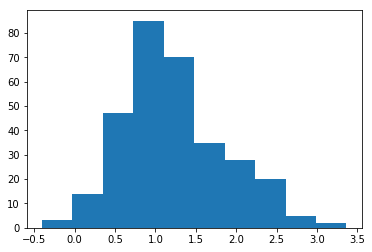

In [20]:
plt.hist(y)

In [36]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.165888,0.083010,0.032106,0.000000,0.000000,0.0,0.000000,0.000000,0.015369,0.066508,...,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.004585,0.000000,0.000000
1,0.109186,0.248636,0.104278,0.086860,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00000,0.091570,0.00000,0.055476,0.002005,0.202621,0.000000,0.000000
2,0.200448,0.110161,0.064544,0.280621,0.002024,0.0,0.059367,0.021337,0.616359,0.118111,...,0.0,0.028854,0.20544,0.086443,0.00000,0.228114,0.442958,0.187212,0.000000,0.000000
3,0.157340,0.999639,0.089045,1.063644,0.000000,0.0,0.000000,0.000000,0.449742,0.000000,...,0.0,0.000000,0.00000,0.000000,0.00784,0.209024,0.095671,0.118751,0.000000,0.079408
4,0.010588,0.176742,0.131168,0.063431,0.000000,0.0,0.092633,0.000000,0.016088,0.000000,...,0.0,0.000000,0.00000,0.000000,0.00000,0.071738,0.148764,0.490005,0.013786,0.000000


# 2. Predicting Continuous Indicator

In [37]:
alphas = np.array([0.01,0.1,1,5,10,20,30,40,50])

In [38]:
model=Ridge()

In [39]:
inner_cv = KFold(n_splits=5, shuffle=True, random_state=1673)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=75788)

In [40]:
def r2_pearson(ground_truth, predictions):
    r2_pearson=stats.pearsonr(ground_truth, predictions)[0] ** 2
    return r2_pearson
r2_pearson = make_scorer(r2_pearson, greater_is_better=True)

In [41]:
#Inner cross-validation loop
clf = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=inner_cv, scoring=r2_pearson)

## From PCA Components

In [42]:
pca = PCA(n_components=10)

In [43]:
pca.fit(data_features.transpose())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
eigenvectors=pca.components_

In [45]:
X2 = pd.DataFrame(np.transpose(eigenvectors))
X2.shape

(309, 10)

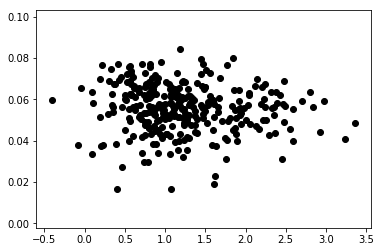

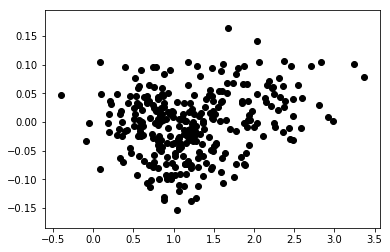

In [46]:
for i in range(2):
    plt.figure()
    plt.scatter(y, eigenvectors[i],  color='black')

In [56]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X2, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2)) 

r2 (pearson): 0.35 (+/- 0.09)


In [57]:
# Outer Loop with R2
r2 = cross_val_score(clf, X2, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

R2: 0.19 (+/- 0.28)


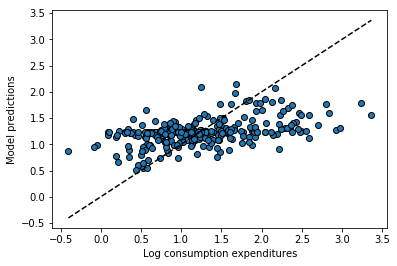

In [49]:
y_hat = cross_val_predict(clf, X2, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

## From all (4096) features

In [50]:
alphas = np.array([1,5,10,20,30,40,50])

In [51]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

r2 (pearson): 0.38 (+/- 0.15)


In [52]:
r2

array([ 0.41347773,  0.50407295,  0.36627695,  0.26542207,  0.36558303])

In [53]:
# Outer Loop with R2
R2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (R2.mean(), R2.std() * 2))

R2: 0.31 (+/- 0.20)


In [54]:
R2

array([ 0.38119058,  0.46541601,  0.29678602,  0.21037747,  0.2030125 ])

In [58]:
neg_mean_squared_error = cross_val_score(clf, X, y, cv=outer_cv,scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (-neg_mean_squared_error.mean(), neg_mean_squared_error.std() * 2)) 

neg_mean_squared_error: 0.27 (+/- 0.04)


In [61]:
-neg_mean_squared_error

array([ 0.25592034,  0.28178149,  0.26240351,  0.29735724,  0.2498313 ])

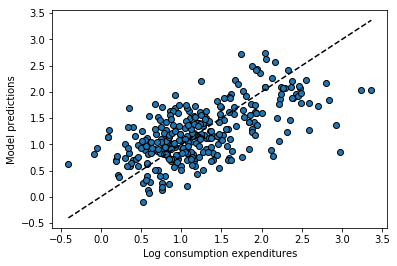

In [62]:
y_hat = cross_val_predict(clf, X, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

In [63]:
r2_score(y,y_hat)

0.3366220833396969

In [64]:
stats.pearsonr(y,y_hat)[0] ** 2

0.37677381537248728

# 3. Predicting Dummy Indicator from all features

In [65]:
model = linear_model.LogisticRegression(penalty="l2")
model.fit(X, y2) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
cv = KFold(n_splits=10, shuffle=True, random_state=167)

In [67]:
accuracy = cross_val_score(model, X, y2, cv=cv)
f1 = cross_val_score(model, X, y2, cv=cv,scoring='f1')
precision = cross_val_score(model, X, y2, cv=cv,scoring='precision')
recall= cross_val_score(model, X, y2, cv=cv,scoring='recall')
auc= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')
confusion= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')

In [68]:
scores = cross_val_score(model, X, y2, cv=10,scoring='precision')
accuracy_print=("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
f1_print=("F1: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))
precision_print=("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
recall_print=("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
auc_print=("AUC: %0.2f (+/- %0.2f)" % (auc.mean(), auc.std() * 2))
print(os.linesep.join([accuracy_print,f1_print,precision_print,recall_print,auc_print]))

Accuracy: 0.79 (+/- 0.09)
F1: 0.53 (+/- 0.26)
Precision: 0.62 (+/- 0.37)
Recall: 0.49 (+/- 0.30)
AUC: 0.82 (+/- 0.14)


In [69]:
y2.describe()

count    309.000000
mean       0.258900
std        0.438741
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: poor_majority, dtype: float64